# Style transfer

There are 3 approaches to style transfer:
- `Supervised Learning` (user shows model how to apply new style to image - requires a lot of data pairs)
- `Neural Style Transfer` (model applies other images style to image)
- `Fast Neural Style Transfer`

---

## Neural Style Transfer

Take content from original image and style from "style" image and create new image by updating the original image with regards to minimizing the `total loss` (content loss + style loss) calculated between two original images.

It is best to extract style from first layer of each `conv_block` (`conv{n}_block1`), and the content from one of the last layers but not he last as the image thes is very small (`conv{last}_block{n`).

We don't train the network but just use it to extract features from two original images to create a new on that minimizez the `total loss`.

![alt text](StyleTransfer.png "Title")

#### Data

In [17]:
content_image = load_img("./images/swan.jpg")
style_image = load_img("./images/painting.jpg")

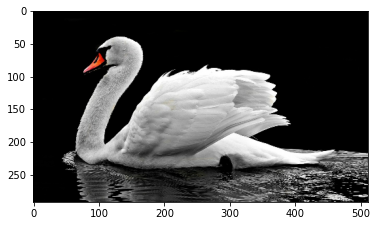

In [18]:
plt.imshow(tf.squeeze(content_image, axis=0))

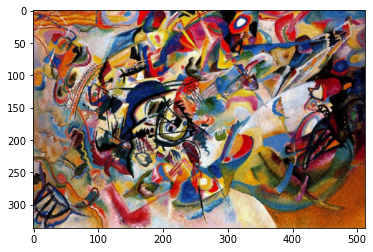

In [19]:
plt.imshow(tf.squeeze(style_image, axis=0))

#### Model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
content_layers=['block5_conv2']
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
layers=content_layers+style_layers

In [3]:
def model(layers):
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    outputs=[vgg.get_layer(layer).output for layer in layers]
    model=tf.keras.models.Model(inputs=vgg.input, outputs=[outputs])

    return model

In [4]:
vgg = model(layers)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Loss

`Content Loss` - sum of squares of difference between pixel values in features (images from chosen model layers).

In [5]:
def content_loss(features, targets):
    weight=0.5
    loss = weight*tf.reduce_sum(tf.square(features - targets))
    #print(f'content: {loss}')
    return loss

`Style Loss` - same as content loss but with style image

In [6]:
def style_loss(features, targets):
    loss = tf.reduce_mean(tf.square(features - targets))
    #print(f'style: {loss}')
    return loss

`Total Loss`

In [7]:
def total_loss(style_targets,style_outputs,content_targets,content_outputs,style_weight,content_weight):
    style_losses = tf.add_n([style_loss(style_output, style_target) for style_output, style_target in zip(style_outputs, style_targets)])
    content_losses = tf.add_n([content_loss(content_output, content_target) for content_output, content_target in zip(content_outputs, content_targets)])
    
    style_losses = style_losses * style_weight / len(style_layers)
    content_losses = content_losses * content_weight / len(content_layers)
    
    total_loss = style_losses + content_losses
    return total_loss

#### Features

In [8]:
def preprocess(image):
    '''centers the pixel values of a given image to use with VGG-19'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [9]:
def gram_matrix(input_tensor):
    result=tf.linalg.einsum('bijc,bijd->bcd',input_tensor, input_tensor)
    input_shape=tf.shape(input_tensor)
    num_locations=tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/num_locations

`content features`

In [11]:
def content_image_features(image):
    preprocessed_image=preprocess(image)
    outputs=vgg(preprocessed_image)
    content_outputs = outputs[0][len(style_layers):]
    return content_outputs

In [54]:
content_features=content_image_features(content_image)

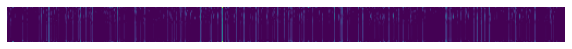

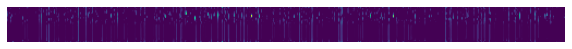

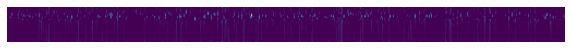

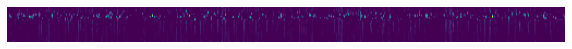

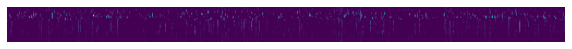

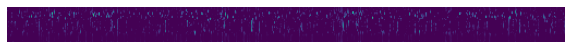

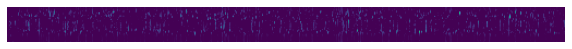

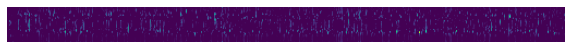

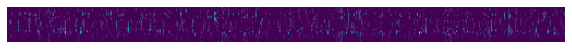

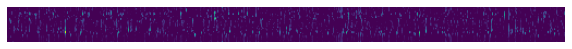

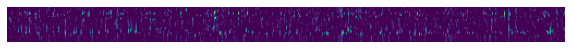

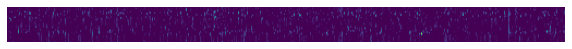

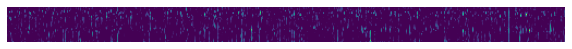

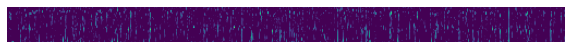

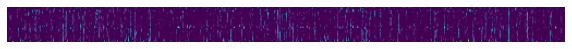

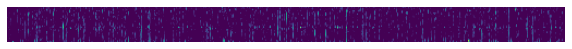

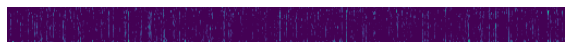

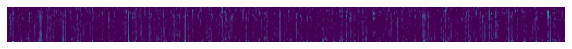

In [83]:
for i in range(18):
    plt.figure(figsize=(10,10))
    plt.imshow(content_features[0][0][i])
    plt.axis('off')
    plt.show()

`style fearures`

In [10]:
def style_image_features(image):
    preprocessed_style_image=preprocess(image)
    outputs=vgg(preprocessed_style_image)
    style_outputs=outputs[0][:len(style_layers)]
    gram_style_features=[gram_matrix(style_layer) for style_layer in style_outputs]
    return gram_style_features

In [53]:
style_features=style_image_features(style_image)

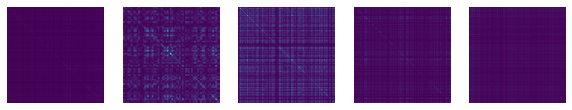

In [81]:
plt.figure(figsize=(10,10))
for i in range(5):
    plot = plt.subplot2grid((1,5), (0, i))
    plot.imshow(tf.squeeze(style_features[i], axis=0))
    plt.axis('off')

#### Gradient

In [12]:
def calculate_gradients(image, style_targets, content_targets, style_weight, content_weight):
    with tf.GradientTape() as tape:
        style_features = style_image_features(image)
        content_features = content_image_features(image)
        loss = total_loss(style_targets, style_features, content_targets,content_features, style_weight, content_weight) 
    gradients = tape.gradient(loss, image)

    return gradients

#### Image update

In [13]:
def update_image_with_style(image, style_targets, content_targets, style_weight, content_weight, optimizer):
    gradients = calculate_gradients(image, style_targets, content_targets, style_weight, content_weight)
    optimizer.apply_gradients([(gradients, image)]) 
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0))

#### Style Transfer

In [14]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, optimizer='adam', epochs=1, steps_per_epoch=1):
    images = []
    step = 0
    
    style_targets = style_image_features(style_image)
    content_targets = content_image_features(content_image)

    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 
    images.append(content_image)
    
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            update_image_with_style(generated_image, style_targets, content_targets, style_weight, content_weight, optimizer) 
            print(".", end='')
            if (m + 1) % 10 == 0:
                images.append(generated_image)
        images.append(generated_image)
        print("Train step: {}".format(step))
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images

In [15]:
def load_img(path_to_img):
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

#### Optimization

In [99]:
style_weight =  2e-2
content_weight = 1e-2
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50))

stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight, optimizer=adam, epochs=3, steps_per_epoch=10)

..........Train step: 10
..........Train step: 20
..........Train step: 30


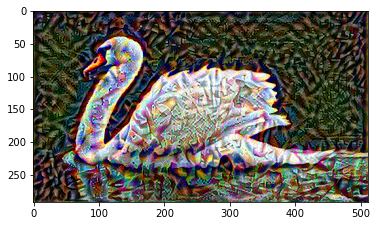

In [101]:
plt.imshow(tf.squeeze(stylized_image, axis=0))

---

## Total Variation Loss

One downside to the implementation above is that it produces a lot of `high frequency artifacts`. You can see this when you plot the frequency variations of the image. We can decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the `total variation loss`.

In [86]:
content_image = load_img("./images/swan.jpg")
stylized_image = load_img("./images/stylized_image.png")

In [89]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

In [91]:
original_x_deltas, original_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(content_image, dtype=tf.float32))
stylized_image_x_deltas, stylized_image_y_deltas = high_pass_x_y(tf.image.convert_image_dtype(stylized_image, dtype=tf.float32))

In [113]:
clipped_y_deltas_orig = tf.clip_by_value(2*original_y_deltas+0.5, clip_value_min=0.0, clip_value_max=1.0)
clipped_x_deltas_orig = tf.clip_by_value(2*original_x_deltas+0.5, clip_value_min=0.0, clip_value_max=1.0)
clipped_y_deltas_styl = tf.clip_by_value(2*stylized_image_y_deltas+0.5, clip_value_min=0.0, clip_value_max=1.0)
clipped_x_deltas_styl = tf.clip_by_value(2*stylized_image_x_deltas+0.5, clip_value_min=0.0, clip_value_max=1.0)
images=[clipped_y_deltas_orig,clipped_x_deltas_orig,clipped_y_deltas_styl,clipped_x_deltas_styl]

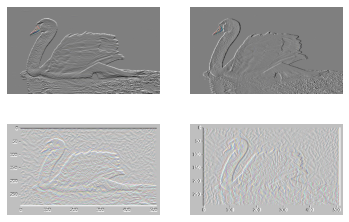

In [116]:
j=1
for i in images:
    plt.subplot(2,2,j)
    plt.imshow(tf.squeeze(i, axis=0))
    plt.axis('off')
    j+=1

#### Gradient

In [84]:
def calculate_gradients(image, style_targets, content_targets, style_weight, content_weight):
    with tf.GradientTape() as tape:
        style_features = style_image_features(image)
        content_features = content_image_features(image)
        loss = total_loss(style_targets, style_features, content_targets,content_features, style_weight, content_weight)
        loss += var_weight*tf.image.total_variation(image)
    gradients = tape.gradient(loss, image) 

    return gradients

#### Optimization

In [ ]:
style_weight =  2e-2
content_weight = 1e-2
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50))

stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight, optimizer=adam, epochs=3, steps_per_epoch=10)

In [ ]:
plt.imshow(tf.squeeze(stylized_image, axis=0))

---

#### Gram matrix

In [9]:
style_layer=tf.constant([1,2,3,4,5,6,7,8],shape=(2,2,2))
style_layer

<tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])>

In [10]:
A=tf.transpose(tf.reshape(style_layer,shape=(2,4)))
A

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]])>

In [11]:
AT=tf.transpose(A)
AT

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 2, 3, 4],
       [5, 6, 7, 8]])>

In [12]:
G=tf.matmul(AT,A)
G

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 30,  70],
       [ 70, 174]])>

or, code from function:

In [14]:
G=tf.linalg.einsum('cij,dij->cd',style_layer, style_layer)
G

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 30,  70],
       [ 70, 174]])>

#### Einstein notation

Allows to calculate the matrix multiplication of transposed matrix and matrix itself in one line

In [17]:
x=tf.constant([1,2,3,4],shape=(2,2))
x

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>

In [18]:
xT=tf.transpose(x)
xT

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 3],
       [2, 4]])>

In [19]:
tf.linalg.einsum('ij,ij->ij',x,x)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 1,  4],
       [ 9, 16]])>

In [20]:
tf.linalg.einsum('ij,ij->ij',xT,x)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 1,  6],
       [ 6, 16]])>

In [21]:
tf.linalg.einsum('ij,jk->ik',xT,x)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10, 14],
       [14, 20]])>

In [22]:
tf.matmul(xT,x)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10, 14],
       [14, 20]])>